# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [109]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import norm
from scipy.optimize import minimize
import datetime as dt
%run functions.py

In [98]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

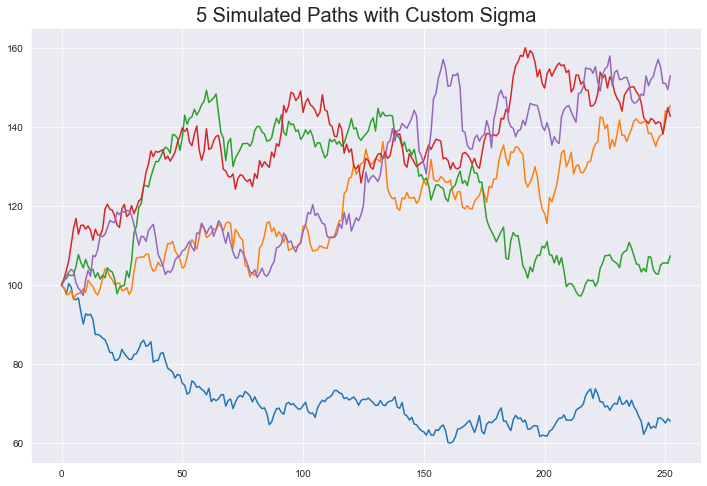

In [99]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

Let us first use monte-carlo method to simulate the call values.  

In [100]:
S0 = 100
t = 1
r = 0.039
mu = 0.0
n_paths = 100000
n_steps = 252*4


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


# plt.figure(figsize = (12,8))

# for path in simulated_paths:
#     plt.plot(path)
    
# plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


# plt.show()

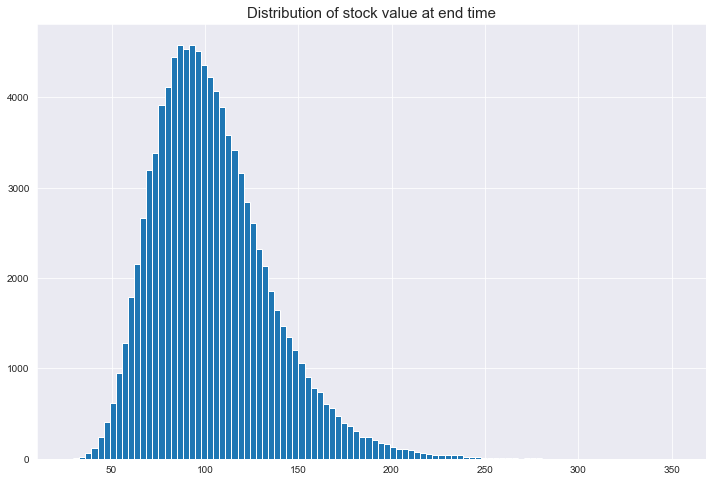

104.08873099789271


In [101]:
end_values = simulated_paths[:, -1]
plt.figure(figsize = (12,8))
plt.hist(end_values,bins = 100)
plt.title('Distribution of stock value at end time', size = 15)

plt.show()
print(np.mean(end_values))

From the numerical experiments, it is apparant that $S(T)$ follow some distribuations, and we could now use those data to simulate the value of a call option with strike price K. Notice here the way $\sigma$ is defined for this model is such that over each time increment it is picked form a set i.i.d distribuation where it is a weighted average of delta functions. We could hypothesis that because the end value is an expoential where the exponent is a sum of all increments, and that the exponent it self could be written as a weighted sum of the exponents of the standard B-S model stock movement. Therefore, the call value pricing of this model could be modeled using the standard B-S model where the $\sigma$ in the formula can be regarded as some type of ``averaging'' of the $\sigma$'s chosen, i.e.

$\sigma_{effective}^2=\displaystyle \sum_{i=1}^3 P_i \sigma_i^2$.

Solving the above equation numerically gives $\sigma_{effective}=\frac{\sqrt{35}}{20}.$
 
We could first test this hypothesis under the risk neural model (set $\mu=0$).

In [106]:
K=100
call_payouts = np.maximum(end_values - K, 0)

call_sim_value = np.exp(-r*t)*np.mean(call_payouts)

print("Monte Carlo call (N = 100000):", call_sim_value)
print("B-S call value under effective σ:", bs_call(S0, K, np.sqrt(35)/20, t, r))
#(call_sim_value, weight_bs_call_value, bs_call(S0, K, np.sqrt(35)/20, t, r))



Monte Carlo call (N = 100000): 13.602391844124964
B-S call value under effective σ: 13.544936653644228


We could see that numerically the monto carlo simulation result is fairly close to the B-S call option value with the ``effective'' volatility. We could try to test the stability of the hedging results using the B-S formula.

In [111]:
import types

In [294]:
S0 = 100
K = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 1000
n_steps = 252
dt = t/n_steps

simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)
end_values = simulated_paths[:, -1]
call_payouts = np.maximum(end_values - K, 0)*np.exp(-r*t)

# call_sim_value = np.exp(-r*t)*np.mean(call_payouts)

delta_start = bs_call_delta(S0,K,np.sqrt(35)/20,t,r)

paths_first_steps = simulated_paths[:,0]

first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)

stock_profits = []

stock_profits.append(first_stock_profits)




## stock profits in intermediate steps

for i in range(1,n_steps):
    stock_start = simulated_paths[:,i-1]
    stock_end = simulated_paths[:,i]
    tte = t-i*dt
    deltas = bs_call_delta(stock_start, K, np.sqrt(35)/20, tte, r)
    
    
    stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
    
    
    stock_profits.append(stock_profit)
    

total_stock_profit = np.sum(stock_profits, axis = 0)

profits_hedged = call_payouts - total_stock_profit

std_err = np.std(profits_hedged)/np.sqrt(n_paths)

#Comparison of simulated value with Black-Scholes

print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_paths} simulations and \
{n_steps} control variants and standard error: {std_err:.6f}')

print('------'*17)
print('------'*17)


print(f'Black Scholes Price of Call Option: ${bs_call(S0,K,np.sqrt(35)/20,t,r):.2f}')

Simulated-Black Scholes Price: $13.52  with 1000 simulations and 252 control variants and standard error: 0.083835
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Black Scholes Price of Call Option: $13.54


We could see that with 1000 simulations and 252 hedges, the call option price with nonzero $\mu$ generated via monte carlo method with the B-S hedging terms as control variants is already close to the numerical value we generated above in the risk neutral envirment with 100000 simulations and both of them are close to the call price predicted using the B-S model with the ''effective'' $\sigma$. Below we provided a histogram for the call option price which has a nice symmetric shape, suggesting that the hedges are effective as control variants. 

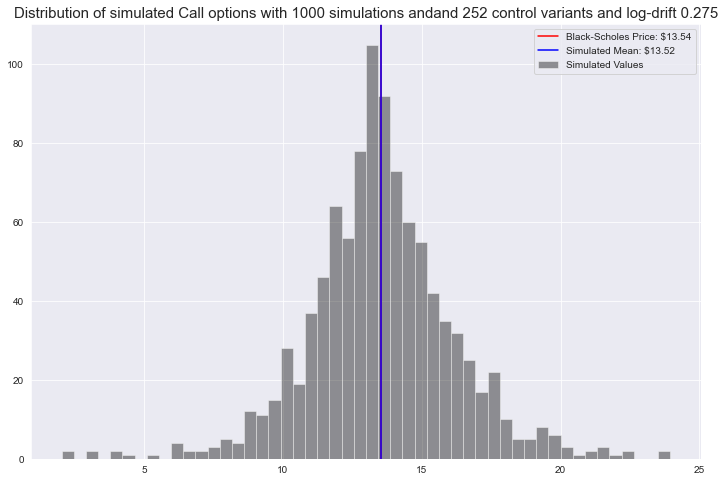

In [295]:
plt.figure(figsize = (12,8))
    
plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
    
bs_price = bs_call(S0,K,np.sqrt(35)/20,t,r)
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
    
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
plt.legend()
    
plt.title(f'Distribution of simulated Call options with {n_paths} simulations and\
and {n_steps} control variants and log-drift {mu}',size = 15)
    
plt.show()

In [272]:
def Exo_MC_call(S0, K, r, t, mu, n_paths, n_steps):
    """
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta-based control variants.

    Parameters:
        S0 (float): Spot price
        K (float): Strike price
        r (float): Risk-free interest rate
        t (float): Time to expiration
        mu (float): Drift of log-returns
        n_paths (int): Number of simulations
        n_steps (int): Number of delta control variants at evenly spaced increments

    Returns:
        np.array: Simulated values of Black-Scholes value of call option

    Warning:
        This function is not a true simulation. The Black-Scholes equation for Delta is not simulated.
    """
    # Simulate stock paths
    simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)
    end_values = simulated_paths[:, -1]
    call_payouts = np.maximum(end_values - K, 0) * np.exp(-r * t)

    # Calculate time step
    dt = t / n_steps

    # Initial delta and first step profits
    delta_start = bs_call_delta(S0, K, np.sqrt(35)/20, t, r)
    paths_first_steps = simulated_paths[:, 0]
    first_stock_profits = (paths_first_steps - S0 * np.exp(dt * r)) * np.exp(-dt * r)

    # Initialize stock profits list
    stock_profits = [first_stock_profits]

    # Calculate stock profits for intermediate steps
    for i in range(1, n_steps):
        stock_start = simulated_paths[:, i-1]
        stock_end = simulated_paths[:, i]
        tte = t - i * dt
        deltas = bs_call_delta(stock_start, K, np.sqrt(35)/20, tte, r)
        stock_profit = (stock_end - stock_start * np.exp(r * dt)) * deltas * np.exp(-i * dt * r)
        stock_profits.append(stock_profit)

    # Calculate total stock profit and hedged profits
    total_stock_profit = np.sum(stock_profits, axis=0)
    profits_hedged = call_payouts - total_stock_profit

    return profits_hedged

We can study the effect of increased number of hedges further by observing the distribution of profits from the Monte Carlo simulations of the hedging process. Here we picked a different strike price K=105 instead of 100.

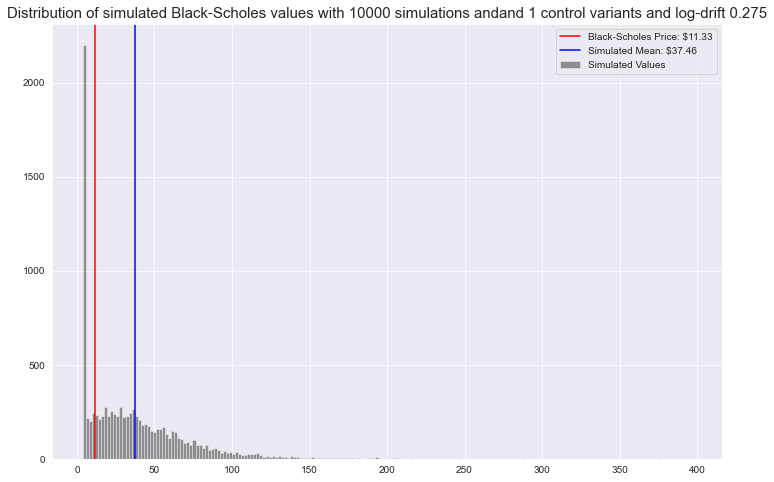

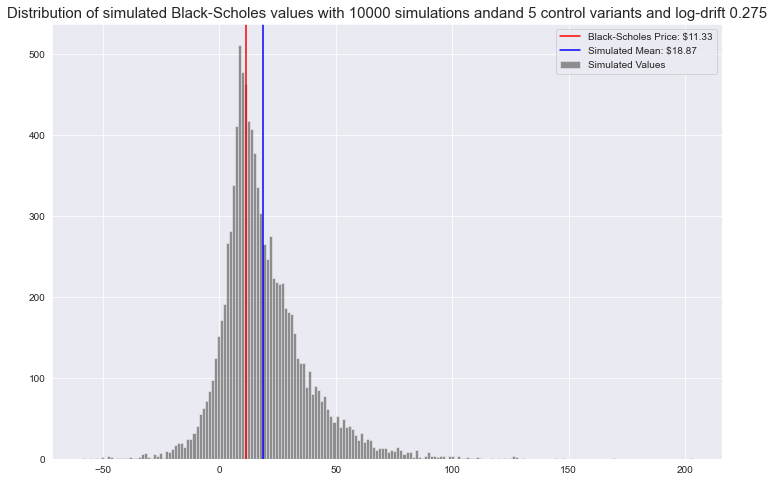

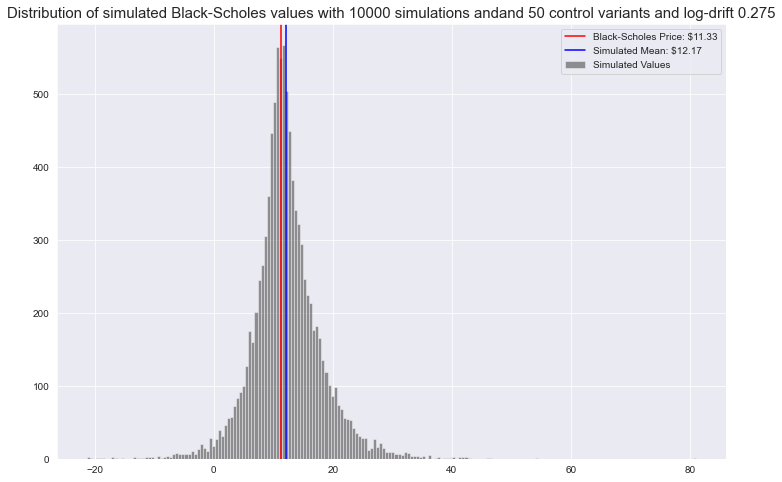

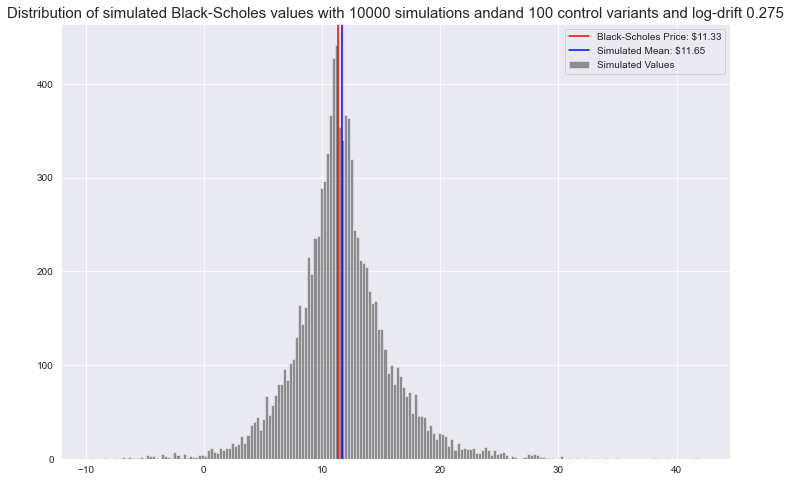

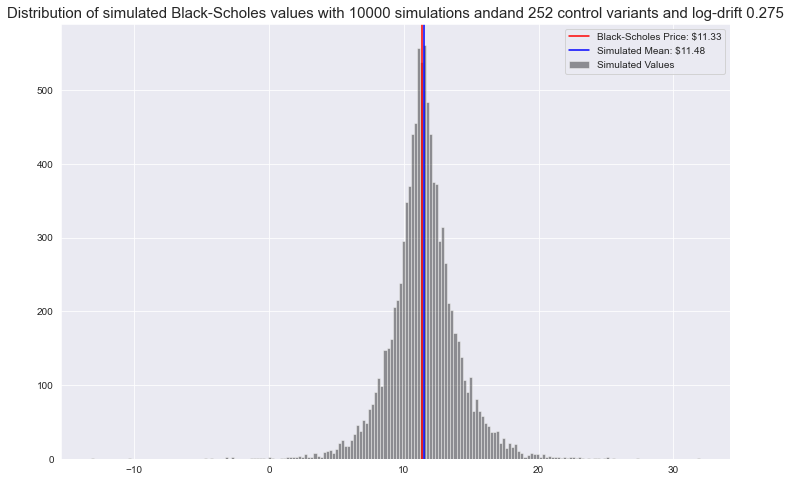

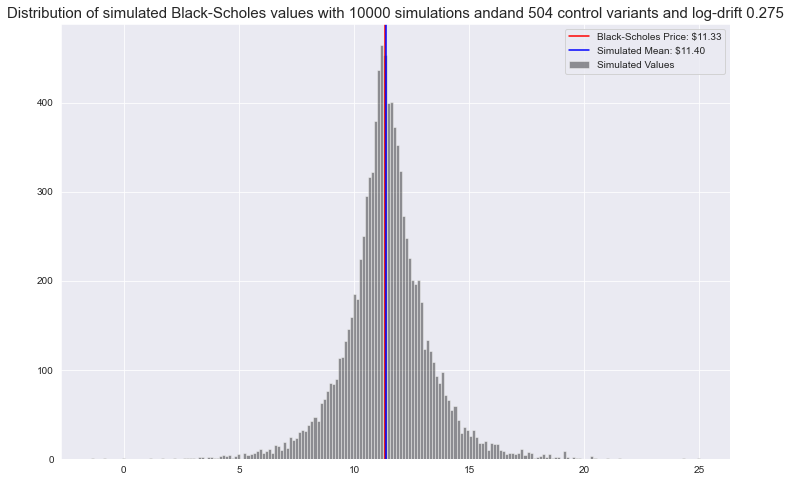

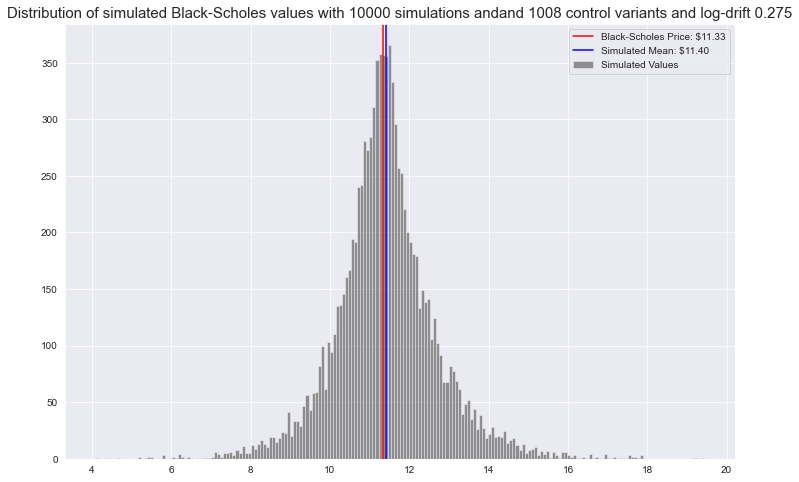

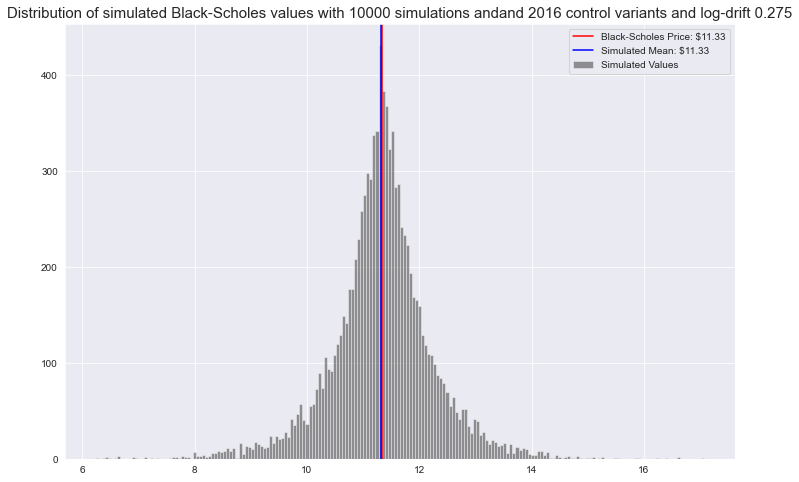

In [297]:
S0 = 100
K = 105
t = 1
r = 0.039
mu = 0.275
n_paths = 10000
n_steps = 252*8

hedging_numbers = [1, 5, 50, 100, 252, 2*252,4*252,8*252]

bs_price = bs_call(S0,K,np.sqrt(35)/20,t,r)

for n_steps in hedging_numbers:
    profits_hedged = Exo_MC_call(S0, K, r, t, mu, n_paths, n_steps)
    
    
    plt.figure(figsize = (12,8))
    
    plt.hist(profits_hedged, bins = 200, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated Black-Scholes values with {n_paths} simulations and\
and {n_steps} control variants and log-drift {mu}',size = 15)
    
    plt.show()

We discover that as the number of hedges increases, the mean value of the final profits is converging to the call option value we calculated using the B-S formula with an effective volatility by a rather hand-waving argument, even in the presence of a nonzero drift term. The result shows us the drift term could be effectively eliminated via a large number of hedges and the effective volatility B-S model appears to be an effective one in pricing the options and lead the hedging strategy.